<a href="https://colab.research.google.com/github/Tandon-A/emotic/blob/master/Colab_train_emotic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Emotions in context (Emotic) </center></h1>
<center> Using context information to recognize emotions in images</center>

<h1>Project context</h1>

Humans use their facial features or expressions to convey how they feel, such as a person may smile when happy and scowl when angry. Historically, computer vision research has focussed on analyzing and learning these facial features to recognize emotions. 
However, these facial features are not universal and vary extensively across cultures and situations. 

<figure>
<img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/face.jpg"> <img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/full_scene.jpg" width="400">
  <figcaption>Fig 1: a) (Facial feature) The person looks angry or in pain b) (Whole scene) The person looks elated.</figcaption>
</figure>


A scene context, as shown in the figure above, can provide additional information about the situations. This project explores the use of context in recognizing emotions in images. 

This project uses the <a href="http://sunai.uoc.edu/emotic/download.html">EMOTIC dataset</a> and follows the methodology as introduced in the paper <a href="https://arxiv.org/pdf/2003.13401.pdf">'Context based emotion recognition using EMOTIC dataset'</a>.

# I. Prepare places pretrained model

In [3]:
import os
import requests

# Create a directory to save the model
os.makedirs("places", exist_ok=True)

# URL of the ResNet model
model_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
model_path = "./places/resnet18_places365.pth.tar"

# Download the model if not already downloaded
if not os.path.exists(model_path):
    print("Downloading ResNet model...")
    response = requests.get(model_url, stream=True)
    with open(model_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")
else:
    print("Model already exists.")


Model already exists.


In [4]:
# Saving the model weights to use ahead in the notebook
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


# II. General imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model 

In [6]:
def corrupt_visual_features(features, corruption_level=0.5):
    mask = torch.rand_like(features) < corruption_level
    corrupted_features = features.clone()
    corrupted_features[mask] = torch.randn_like(corrupted_features[mask])
    return corrupted_features

In [7]:
def corrupt_textual_features(features, corruption_level=0.5):
    mask = torch.rand_like(features) < corruption_level
    corrupted_features = features.clone()
    corrupted_features[mask] = torch.randn_like(corrupted_features[mask])
    return corrupted_features

In [8]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.fc1 = nn.Linear((self.num_context_features + num_body_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cat = nn.Linear(256, 26)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()

    
  def forward(self, x_context, x_body, corrupt_visual=False, corrupt_textual=False):
    if corrupt_visual:
      x_body = corrupt_visual_features(x_body)
    if corrupt_textual:
      x_context = corrupt_textual_features(x_context)
    context_features = x_context.view(-1, self.num_context_features)
    body_features = x_body.view(-1, self.num_body_features)
    fuse_features = torch.cat((context_features, body_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)    
    cat_out = self.fc_cat(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cat_out, cont_out
  
  def corrupt_features(self, features, corruption_level=0.5):
    mask = torch.rand_like(features) < corruption_level
    corrupted_features = features.clone()
    corrupted_features[mask] = torch.randn_like(corrupted_features[mask])
    return corrupted_features

print ('completed cell')

completed cell


## Emotic Dataset

In [9]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.y_cat = y_cat 
    self.y_cont = y_cont
    self.transform = transform 
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)
  
  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [10]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)
    
  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum() 

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [11]:
# Change data_src variable as per your drive
data_src = 'D:/Ruturaj/New folder (3)/Ruturaj/Smart Systems/MANAV Experiment/proj/data/emotic19/emotic_pre'


# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'train_cont_arr.npy'))

# Load validation preprocessed data 
val_context = np.load(os.path.join(data_src,'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [12]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]


train_transform = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(), 
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat, train_cont, \
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont, \
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont, \
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. Prepare emotic model

In [13]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))


# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


completed cell


## Prepare optimizer

In [14]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

print ('completed cell')

completed cell


# VI. Train model

In [15]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=0.5, cont_loss_param=0.5):
  if not os.path.exists(model_path):
    os.makedirs(model_path)
  
  min_loss = np.inf

  train_loss = list()
  val_loss = list()

  model_context, model_body, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_body.to(device)
    
    emotic_model.train()
    model_context.train()
    model_body.train()
    
    for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)

      pred_cat, pred_cont = emotic_model(pred_context, pred_body, corrupt_visual=False, corrupt_textual=False)
      cat_loss_batch = disc_loss(pred_cat, labels_cat)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
      running_loss += loss.item()
      loss.backward()
      opt.step()

    if e % 1 == 0: 
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)

    
    running_loss = 0.0 
    emotic_model.eval()
    model_context.eval()
    model_body.eval()
    
    with torch.no_grad():
      for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)
        
        pred_cat, pred_cont = emotic_model(pred_context, pred_body, corrupt_visual=False, corrupt_textual=False)
        cat_loss_batch = disc_loss(pred_cat, labels_cat)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
        running_loss += loss.item()

      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
      
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

  print ('completed training')
  
  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train'])
  ax2.legend(['val'])

print ('completed cell')

completed cell


epoch = 0 training loss = 64092.3838
epoch = 0 validation loss = 6386.5922
saving model at epoch e = 0
epoch = 1 training loss = 47820.8408
epoch = 1 validation loss = 6002.4822
saving model at epoch e = 1
epoch = 2 training loss = 45779.4103
epoch = 2 validation loss = 5747.3316
saving model at epoch e = 2
epoch = 3 training loss = 44368.5087
epoch = 3 validation loss = 5748.7575
epoch = 4 training loss = 43517.6280
epoch = 4 validation loss = 5743.7578
saving model at epoch e = 4
epoch = 5 training loss = 42898.9115
epoch = 5 validation loss = 5641.4072
saving model at epoch e = 5
epoch = 6 training loss = 42521.5473
epoch = 6 validation loss = 5552.8323
saving model at epoch e = 6
epoch = 7 training loss = 41868.7331
epoch = 7 validation loss = 5519.8276
saving model at epoch e = 7
epoch = 8 training loss = 41511.5321
epoch = 8 validation loss = 5542.1382
epoch = 9 training loss = 41367.1729
epoch = 9 validation loss = 5597.4367
epoch = 10 training loss = 41334.1185
epoch = 10 valid

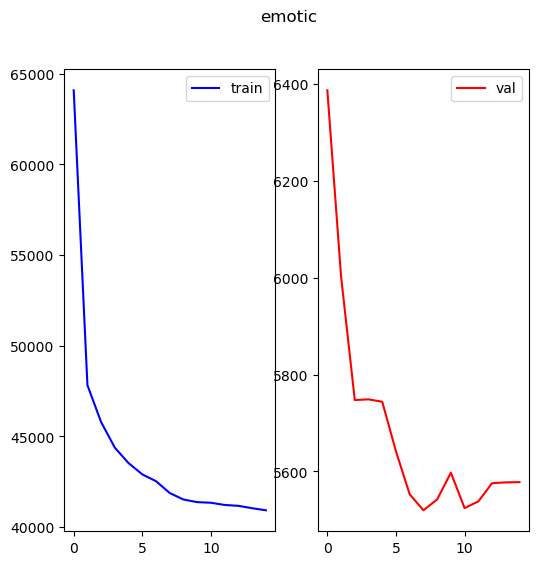

In [16]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1)

# VII. Test model

In [17]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [18]:
def test_data(models, device, data_loader, num_images, corrupt_visual=False, corrupt_textual=False):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_cat, pred_cont = emotic_model(pred_context, pred_body, corrupt_visual=corrupt_visual, corrupt_textual=corrupt_textual)

            cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10 
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (ap_mean, vad_mean)
    return ap_mean, vad_mean

def compare_experiments(models, data_loader, device):
    results = {
        'No Corruption': test_data(models, device, data_loader, data_loader.dataset.__len__()),
        'Visual Corruption': test_data(models, device, data_loader, data_loader.dataset.__len__(), corrupt_visual=True),
        'Textual Corruption': test_data(models, device, data_loader, data_loader.dataset.__len__(), corrupt_textual=True),
        'Both Corrupted': test_data(models, device, data_loader, data_loader.dataset.__len__(), corrupt_visual=True, corrupt_textual=True)
    }
    return results 

print ('completed cell')

completed cell


In [19]:
model_context = torch.load('./models/model_context1.pth', weights_only=False)
model_body = torch.load('./models/model_body1.pth', weights_only=False)
emotic_model = torch.load('./models/model_emotic1.pth', weights_only=False)

print ('completed cell')

completed cell


In [20]:
results = compare_experiments([model_context, model_body, emotic_model], test_loader, device)

starting testing
completed testing
ap [0.29055807 0.08551755 0.14380305 0.56273407 0.06946183 0.7582472
 0.12378977 0.23391075 0.1550017  0.16786514 0.01995935 0.86571026
 0.15497075 0.6926211  0.09307674 0.06055126 0.6574559  0.06395841
 0.22207296 0.41526663 0.16575974 0.05958124 0.17345811 0.08799687
 0.12593089 0.07289724] (26,) 0.25085217
vad [0.9055774 1.0224347 0.9502303] (3,) 0.9594142
0.25085217 0.9594142
starting testing
completed testing
ap [0.29189056 0.08375715 0.13915184 0.56505287 0.06665442 0.7394867
 0.11585105 0.23371556 0.15281516 0.16868073 0.01931988 0.8635002
 0.14796433 0.67770576 0.09282322 0.05786553 0.63734335 0.0668626
 0.2223867  0.3974487  0.15805626 0.05900796 0.16834028 0.08327749
 0.12974742 0.07150712] (26,) 0.24654664
vad [0.934718  1.0460812 0.9554869] (3,) 0.978762
0.24654664 0.978762
starting testing
completed testing
ap [0.2555174  0.07917243 0.12225468 0.5580766  0.06631047 0.7322754
 0.10540498 0.21830359 0.14765528 0.16600035 0.02032591 0.852898

C:\Users\admin\AppData\Local\Temp\ipykernel_11292\1744349380.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(experiments, rotation=45, ha='right')
C:\Users\admin\AppData\Local\Temp\ipykernel_11292\1744349380.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(experiments, rotation=45, ha='right')


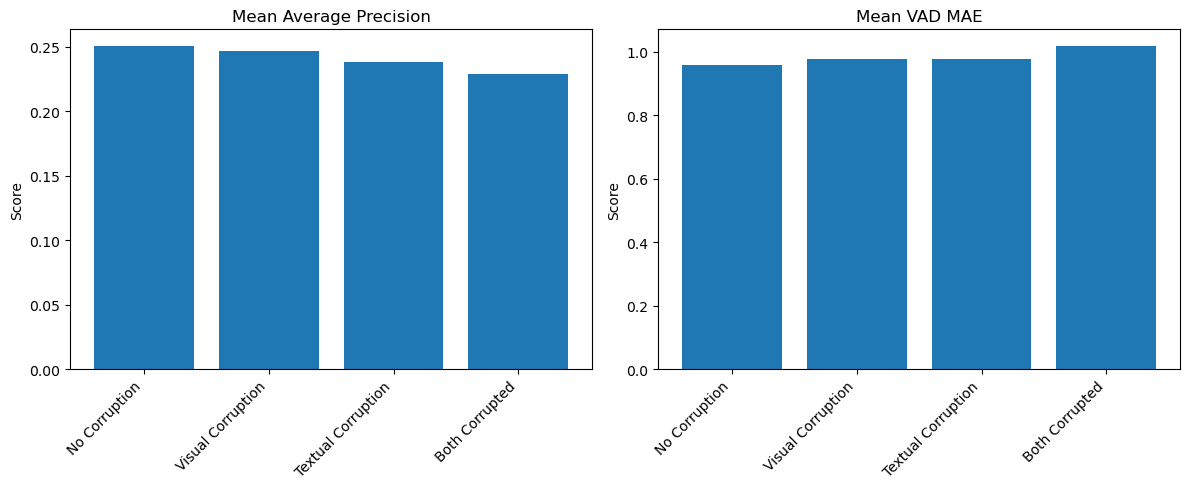

No Corruption: Mean AP = 0.2509, Mean VAD MAE = 0.9594
Visual Corruption: Mean AP = 0.2465, Mean VAD MAE = 0.9788
Textual Corruption: Mean AP = 0.2379, Mean VAD MAE = 0.9786
Both Corrupted: Mean AP = 0.2286, Mean VAD MAE = 1.0203


In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
experiments = list(results.keys())
ap_scores = [result[0] for result in results.values()]
vad_scores = [result[1] for result in results.values()]

ax1.bar(experiments, ap_scores)
ax1.set_title('Mean Average Precision')
ax1.set_ylabel('Score')
ax1.set_xticklabels(experiments, rotation=45, ha='right')

ax2.bar(experiments, vad_scores)
ax2.set_title('Mean VAD MAE')
ax2.set_ylabel('Score')
ax2.set_xticklabels(experiments, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print results
for exp, (ap, vad) in results.items():
    print(f'{exp}: Mean AP = {ap:.4f}, Mean VAD MAE = {vad:.4f}')

In [18]:
val_ap, val_vad = test_data([model_context, model_body, emotic_model], device, val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context, model_body, emotic_model], device, test_loader, test_dataset.__len__())

print ('validation Mean average precision=%.4f Mean VAD MAE=%.4f' %(val_ap, val_vad))
print ('testing Mean average precision=%.4f Mean VAD MAE=%.4f' %(test_ap, test_vad))

starting testing
completed testing
ap [0.39436495 0.19270036 0.22184554 0.94953364 0.17729287 0.7884376
 0.24677986 0.36259302 0.18622294 0.21684706 0.06651057 0.9822566
 0.27360338 0.7928655  0.126005   0.07602997 0.8030723  0.15820077
 0.29068172 0.49621522 0.20274664 0.07263183 0.17966904 0.1489278
 0.3585716  0.11707196] (26,) 0.341603
vad [0.7152154  0.85137486 0.8698979 ] (3,) 0.8121627
0.341603 0.8121627
starting testing
completed testing
ap [0.27845243 0.09137129 0.14032869 0.561723   0.06600961 0.75662696
 0.11927942 0.240255   0.14919254 0.1705907  0.02379147 0.86818165
 0.15895918 0.6924429  0.09314387 0.06164789 0.66105014 0.07339784
 0.21809705 0.42095968 0.17158122 0.0610911  0.17475651 0.09187066
 0.13221517 0.07507887] (26,) 0.25200364
vad [0.9030669  1.0229193  0.94695306] (3,) 0.95764637
0.25200364 0.95764637
validation Mean average precision=0.3416 Mean VAD MAE=0.8122
testing Mean average precision=0.2520 Mean VAD MAE=0.9576


In [19]:
cat_labels = scipy.io.loadmat('./cat_labels.mat')
cat_preds = scipy.io.loadmat('./cat_preds.mat')
cat_preds = cat_preds['cat_preds']
cat_labels = cat_labels['cat_labels']
print (cat_preds.shape, cat_labels.shape)

#thesholds calculation for inference 
thresholds = get_thresholds(cat_preds, cat_labels)
print (thresholds, thresholds.shape)

print ('completed cell')

(26, 7203) (26, 7203)
[0.11949907 0.3567471  0.17453204 0.17905283 0.2295468  0.12536435
 0.2104578  0.10880016 0.07119566 0.06991508 0.1395814  0.47866744
 0.07306163 0.15185377 0.10761315 0.12078899 0.22220406 0.25468704
 0.11007513 0.10525985 0.17919686 0.12964354 0.27605653 0.10330269
 0.10192328 0.08350187] (26,)
completed cell


# VIII. Average Precision computation using <a href="https://1drv.ms/u/s!AkYHbdGNmIVCgbYZB_dY3wuWJou_5A?e=jcsZUj">author's script</a>

In [20]:
!apt install octave

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [21]:
%%writefile eval.m

gt = load('./cat_labels.mat')
gt = gt.cat_labels

pred = load('./cat_preds.mat')
pred = pred.cat_preds

categories{1} = 'Affection';
categories{2} = 'Anger';
categories{3} = 'Annoyance';
categories{4} = 'Anticipation';
categories{5} = 'Aversion';
categories{6} = 'Confidence';
categories{7} = 'Disapproval';
categories{8} = 'Disconnection';
categories{9} = 'Disquietment';
categories{10} = 'Doubt/Confusion';
categories{11} = 'Embarrassment';
categories{12} = 'Engagement';
categories{13} = 'Esteem';
categories{14} = 'Excitement';
categories{15} = 'Fatigue';
categories{16} = 'Fear';
categories{17} = 'Happiness';
categories{18} = 'Pain';
categories{19} = 'Peace';
categories{20} = 'Pleasure';
categories{21} = 'Sadness';
categories{22} = 'Sensitivity';
categories{23} = 'Suffering';
categories{24} = 'Surprise';
categories{25} = 'Sympathy';
categories{26} = 'Yearning';


for c = 1:length(categories)
  confidence = pred(c,:)'; 
  testClass = gt(c,:)';
  confidence = double(confidence);

  S = rand('state');
  rand('state',0);
  confidence = confidence + rand(size(confidence))*10^(-10);
  rand('state',S)

  [S,j] = sort(-confidence);
  C = testClass(j);
  n = length(C);
    
  REL = sum(C);
  if n>0
    RETREL = cumsum(C);
    RET    = (1:n)';
  else
    RETREL = 0;
    RET    = 1;
  end

  precision = 100*RETREL ./ RET;
  recall    = 100*RETREL  / REL;
  th = -S;

  % compute AP
  mrec=[0 ; recall ; 100];
  mpre=[0 ; precision ; 0];
  for i=numel(mpre)-1:-1:1
    mpre(i)=max(mpre(i),mpre(i+1));
  end
  i=find(mrec(2:end)~=mrec(1:end-1))+1;
  averagePrecision=sum((mrec(i)-mrec(i-1)).*mpre(i))/100;
  ap_list(c)  = averagePrecision
end

display('#######################################')

display('Average precision of predictions');
for c = 1:length(categories)
    sp = '............................';
    cat = strcat(categories{c}, sp);
    cat = cat(1:18);
    display(cat);
    display(ap_list(c));
end

Writing eval.m


In [22]:
!octave -W eval.m

'octave' is not recognized as an internal or external command,
operable program or batch file.
